# **[Supervised Workflow]** Remote Sensing Analysis of Mangrove Forest Health and Extent in the Grand-Pierre Bay, Artibonite, Haiti 
## Preprocessing of Final Images to be Classified
<hr>

Written by Alexandre Erich Sebastien Georges, *PhD Student at UC Berkeley in EFMH-Civil and Environmental Engineering*, August 2023

In [1]:
import itertools, glob, re, datetime, copy

from ipywidgets import FloatProgress

from joblib import dump, load

import cv2 as cv
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import earthpy.plot as ep
import matplotlib.pyplot as plt


import matplotlib.patches as mpatches
from matplotlib import colors as colors_mat

from tqdm.notebook import tqdm

from pyproj import CRS

import sys
sys.path.append('/global/home/users/alexandregeorges/Chapter1/')

from codebase.params import *
from codebase.utils import *

In [2]:
# Optional: Crop images
#from scripts import crop

# Data Acquisition

Site Selection

In [3]:
# Options include : ['CCHT', 'GSHT', 'BRHT', 'COHT', 'IVHT', 'AQHT', 'MGHT', 'ARHT', 'OKHT']
site_code = 'GPHT_seaward'
aoi_list = [site_code]

Acquiring Raster Files

In [4]:
data_dir = DOWNLOAD_DIR_ROOT + site_code + '/'+ '*.tif'

# Timestamps for acquired raster files
times = [i.strftime('%m-%d-%Y') for i in paths_to_datetimeindex(glob.glob(data_dir))]
time_var = xr.Variable('Observation Date', times)

In [5]:
sites = []
resSites = []

for area in tqdm(aoi_list):
    aoi = gpd.read_file(aoi_path(area))
    geotiffs_da = xr.concat(
        [rxr.open_rasterio(entry) 
        for entry in tqdm(sort_observations(data_dir))], dim=time_var)
    area_ds = geotiffs_da.to_dataset(dim='Observation Date').rio.write_crs('WGS84', inplace=True)
    sites.append(area_ds)
    resSites.append(area_ds.rio.resolution()[0])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Quick Preview

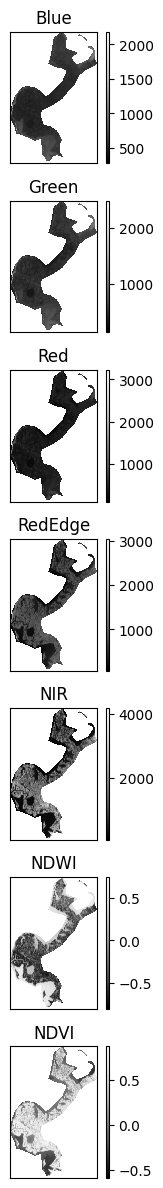

In [6]:
band_titles = ['Blue', 'Green', 'Red', 'RedEdge', 'NIR', 'NDWI', 'NDVI']
ep.plot_bands(sites[0][times[-1]], cols=1, title=band_titles);

In [7]:
import matplotlib as mpl

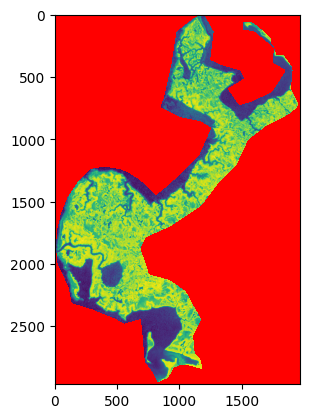

In [8]:
cmap = mpl.cm.viridis
cmap.set_bad('red',1.)
plt.imshow(sites[0][times[0]][-1], cmap = cmap)

# Feature Masking

Deep Copying for easy reversal

In [9]:
sites_mask = copy.deepcopy(sites)

## Open Water and Non-Vegetation Masking

NDWI is used to mask out open water from images, removing one feature to classify. <br>
The threshold used is NDWI >= 0.2 for open water *(insert citation)*

NDVI is used to mask out non-vegetative features from images. <br>
The threshold used is NDVI <= 0.2 for non-vegetation *(insert citation)*

In [10]:
for i, site in enumerate(tqdm(sites_mask)):
    for time in times:
        obs = site[time]
        ndvi_copy = obs[-1].copy()
        ndwi_copy = obs[-2].copy()
        for j, band in enumerate(obs):
            # Masking open water out of band
            new_band = np.ma.masked_where(ndwi_copy > 0.2, band)
            # Masking non-vegetation out of band
            #new_band = np.ma.masked_where(ndvi_copy <= 0.18, new_band)
            # Saving to site 
            site[time][j] = new_band

  0%|          | 0/1 [00:00<?, ?it/s]

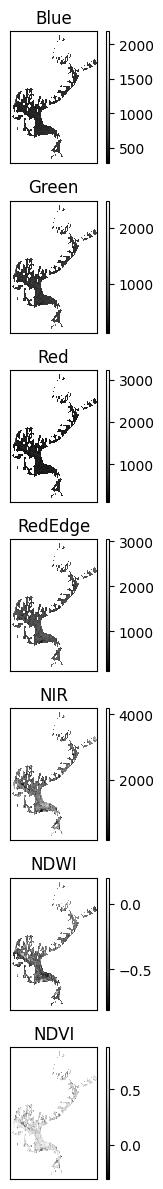

In [11]:
band_titles = ['Blue', 'Green', 'Red', 'RedEdge', 'NIR', 'NDWI', 'NDVI']
ep.plot_bands(sites_mask[0][times[-1]], cols=1, title=band_titles);

/global/home/users/alexandregeorges/.conda/envs/MangroveRS/lib/python3.11/site-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


<Axes: >

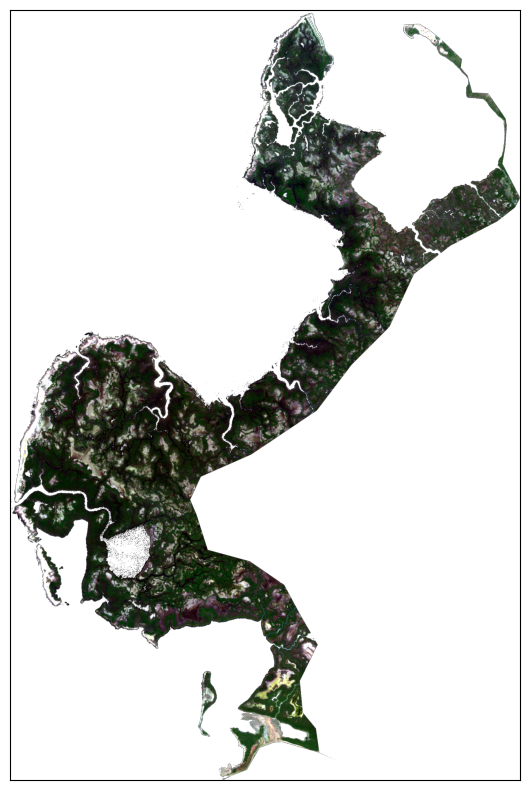

In [12]:
fig, ax = plt.subplots(figsize=(15,10))
ep.plot_rgb(sites_mask[0][times[0]], rgb=[2,1,0], stretch=True, ax=ax)

In [13]:
np.unique(sites_mask[0][times[0]])

array([-9.3740505e-01, -9.3341708e-01, -9.3129772e-01, ...,
        4.1740000e+03,  4.1750000e+03,            nan], dtype=float32)

# Export

In [14]:
sites_mask[0].to_netcdf(OBS_PREFIX+site_code+'_obs.nc')

In [15]:
#OBS_PREFIX+site_code+'_obs.nc'